**TITLE**

**Introduction**<br>
This project will investigate whether the number of rank points a player has in a professional tennis match can be predicted, and what factors are useful in making the prediction. Determining whether the number of rank points can be predited will be done by running k-nearest neighbour regression and linear regression on Jeff Sackmann's "Game results for Top 500 Players from 2017-2019" dataset. Sackmann's dataset includes a collecton of tennis matches containing information on various tournaments, the surface the match was played on, the date the match occured on, and many other variables. This project will use players' height, break point save percentage, and number of double faults in order to predict the number of rank points a player has. Rank points determine a player's position in the global ranking. Break points occur when a player has the opportunity to win the game on their opponent's serve. Saving a break point occurs when the serving player is in a break point position and manages to win the game (tennis matches are made up of multiple sets, which consist of multiple games). Therefore, a break point save percentage is the percentage of break points saved out of break point situations faced. Double faults occur when a player makes two consecutive faults during their serve. A preliminary analysis looking at the relationship between each of these factors independently and rank points indicates possible patterns which will hopefully translate to predictive power in our knn regression. Reid et al. gathered the statistics from the top 100 male professional players of the Association of Tennis Professionals. As seen in Table 1, among the top 100 males an average of 60.5% of break points were saved (Reid et al., 2010). Additionally, an average of 2.55 double faults occured per match among the top 100 male tennis players (Reid et al., 2010). The data seen below explores Jeff Sackmann's "Game results for Top 500 Players from 2017-2019" dataset. 

**Methods & Results**

*Description of Analysis* <br>
    Upon initially loading the tennis dataset it contained several variables realated to  the tournament, the surface it was played upon, as well as its date and location. Additionally, there was plenty information regarding the players' respective indentities and career statistics, and each row represented a singular tennis match. The variables which were unrelated to specific players and performance were eliminated. The data was first wrangled and cleaned as the relavant data from each player category were selected. The relavent varibles were divided into winner and loser data eliminating unnecessary obseravationis such as saved and faced break points. Both of these datafrmes were combined into one and called 'player_data' and this was then split into training and testing sets. Using the training set, an exposition table was made and used to visualize the filtered data. The data was then visualized by creating scatter plots of three main variables - height, double faults, and break point save percentage - versus the given rank points.
    In order to optimize our model, multiple values were tested and cross validation was run on each of them to find the lowest root-mean-square error or RMSE. The k-nearest neighbours regression algorithm was ran on the dataframe and the data was scaled and centered accordingly. First a recipe was created to predict the number of rank points the player would have using the three preselected variables. The training data set was tuned, with the engine set to be kknn and the mode was set to regression. Following, as the recipe and traiing data set were created they were both added to a workflow. A cross validation was performed on the training set, and the accurcy of the regression was found using the RMSE formula. Using the results of the knn training set, they were filtered and used to find the k-valuew with the lowest RMSE. The cross validation was plotted unising a line graph to visualize the mean and the neighbors showing the optimal values to use. Next a data analysis was performed using the optimal predictors and k-values from the previous tuning.
    The current data was put through a linear regression and adjusted to make the regression coefficients more easily interpretable. Within the training data the break point save ratio was changed to a percentage and the differnece between each players' height and the average players' height was found. The predicators within the training set were tuned, and finally put through the model and testing.

*Preparing Code & Data, Splitting Data*

In [44]:
options(repr.matrix.max.rows = 6)

# loading libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [45]:
# loading the data from the web

tennis_data <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn", show_col_types = FALSE)

tennis_data

New names:
• `` -> `...1`


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667
2884,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,4,105676,NA,⋯,54,44,13,14,7,10,7,3775,15,2320
2885,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,5,106298,NA,⋯,53,29,11,11,4,11,18,2235,76,667


In [48]:
set.seed(2132)
# wrangling and cleaning data

# selecting relevant data from each player category (winners & losers), filtering observations, creating new variables, and renaming variables
winner_data <- tennis_data |> select(winner_rank_points, winner_ht, w_df, w_bpSaved, w_bpFaced, w_ace, winner_age) |> # selecting relevant variables
    mutate(bp_percent = (w_bpSaved/w_bpFaced)*100) |> na.omit() |> # creating new variable bp_percent
    rename(rank_points = winner_rank_points, height = winner_ht, double_faults = w_df, ace = w_ace, age = winner_age) |> # renaming variables
    select(-w_bpSaved, -w_bpFaced) # removing now-unnecessary variables

loser_data <- tennis_data |> select(loser_rank_points, loser_ht, l_df, l_bpSaved, l_bpFaced, l_ace, loser_age) |> # selecting relevant variables
    mutate(bp_percent = (l_bpSaved/l_bpFaced)*100) |> na.omit() |> # creating new variable bp_percent
    rename(rank_points = loser_rank_points, height = loser_ht, double_faults = l_df, ace = l_ace, age = loser_age) |> # renaming variables
    select(-l_bpSaved, -l_bpFaced) # removing now-unnecessary variables

# combining losing and winning players' data into one dataframe
player_data <- rbind(winner_data, loser_data)

# splitting the data into training and testing
player_split <- initial_split(player_data, prop = .75, strata = rank_points)  
player_train <- training(player_split)
player_test <- testing(player_split)
player_train

rank_points,height,double_faults,ace,age,bp_percent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200,188,2,12,33.70568,80.00000
200,188,3,11,33.70568,57.14286
200,188,1,11,33.70568,66.66667
⋮,⋮,⋮,⋮,⋮,⋮
2975,163,5,10,26.93498,73.33333
2235,185,2,6,23.73990,54.54545
2320,188,3,10,32.59411,70.00000


*Exposition Table*

player_train_leng,rp_avg,rp_max,rp_min,height_avg,height_max,height_min,df_avg,bp_percent_avg
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6146,1746.893,12560,1,186.2519,208,163,3.113733,59.17036


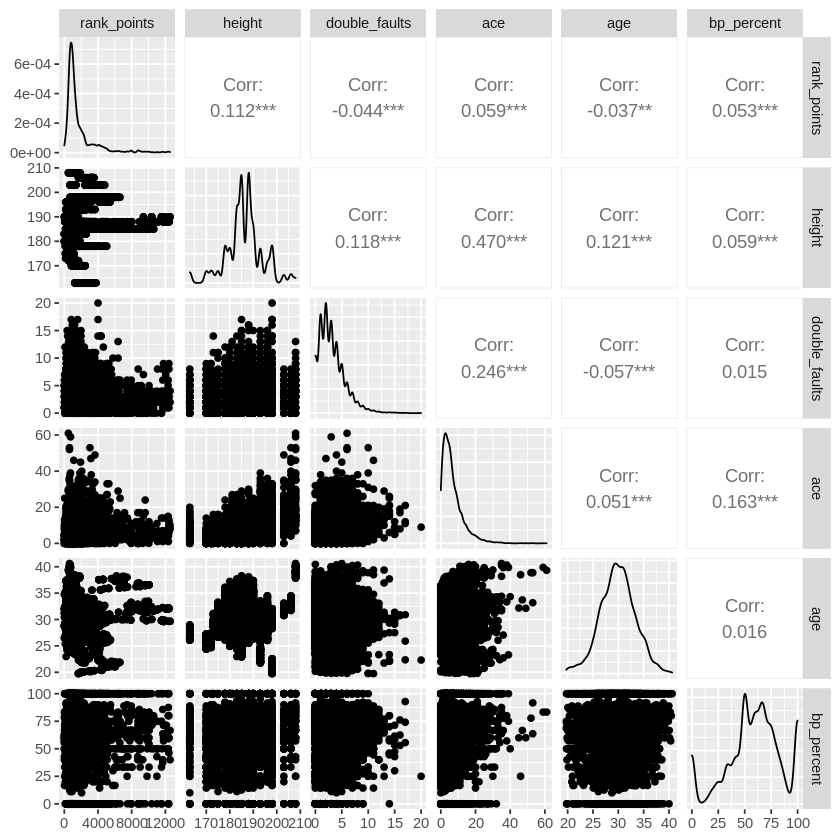

In [49]:
# data exposition

exposit_table <- tibble("player_train_leng" = nrow(player_train), 
                       "rp_avg" = mean(player_train$rank_points),
                       "rp_max" = max(player_train$rank_points),
                       "rp_min" = min(player_train$rank_points),
                       "height_avg" = mean(player_train$height),
                       "height_max" = max(player_train$height),
                       "height_min" = min(player_train$height),
                       "df_avg" = mean(player_train$double_faults),
                       "bp_percent_avg" = mean(player_train$bp_percent))
exposit_table

player_pairs <- player_train |> ggpairs()
player_pairs

*Exposition Table Description*<br>
Write here

*Data Visualizations*

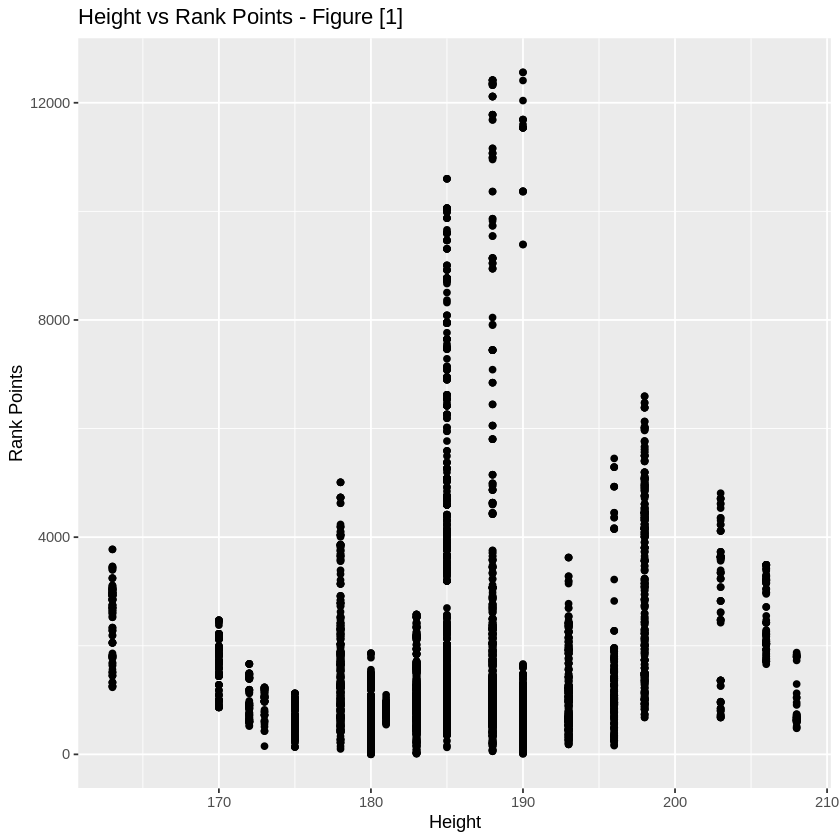

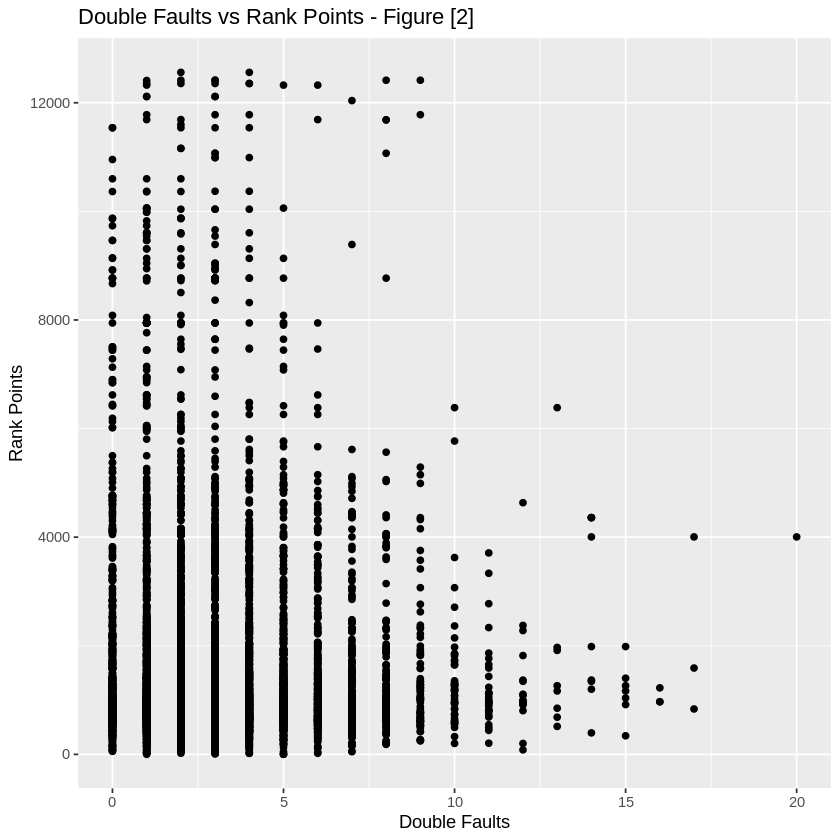

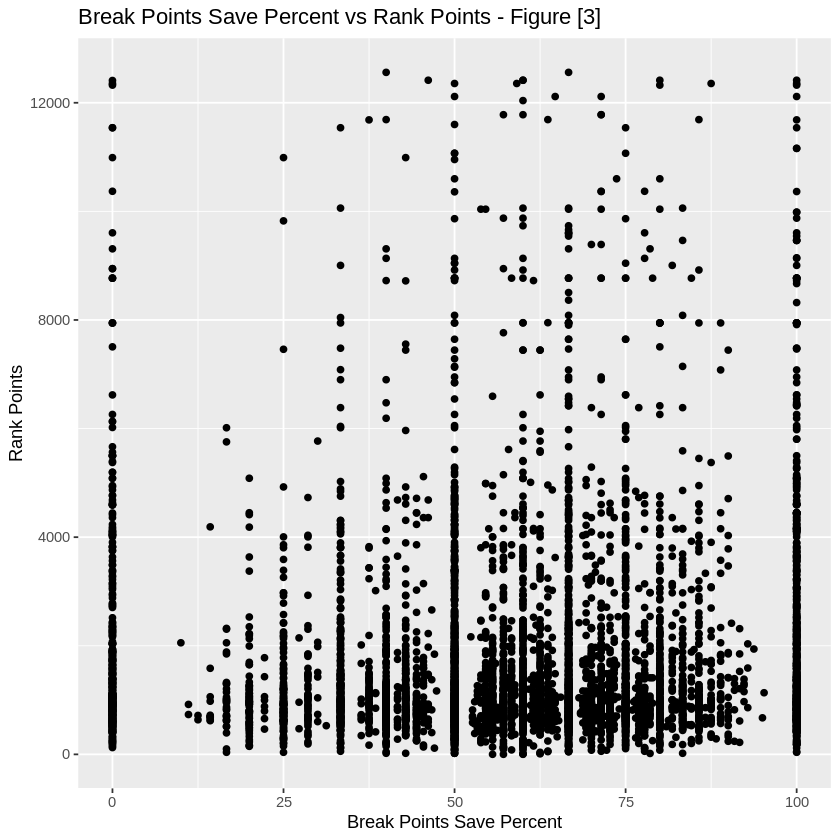

In [43]:
# data visualizations

# plot of height vs rank points
height_plot <- ggplot(player_train, aes(x = height, y = rank_points)) +
    geom_point() +
    labs(title = "Height vs Rank Points - Figure [1]", x = "Height", y = "Rank Points")
height_plot

# plot of double faults vs rank points
df_plot <- ggplot(player_train, aes(x = double_faults, y = rank_points)) +
    geom_point() +
    labs(title = "Double Faults vs Rank Points - Figure [2]", x = "Double Faults", y = "Rank Points")
df_plot

# plot of break point save percent vs rank points
bp_percent_plot <- ggplot(player_train, aes(x = bp_percent, y = rank_points)) +
    geom_point() +
    labs(title = "Break Points Save Percent vs Rank Points - Figure [3]", x = "Break Points Save Percent", y = "Rank Points")
bp_percent_plot

*Data Visualization Descriptions*<br>
The above figures show the relationship between our three predictor variables of interest and our dependent variable. As can be seen, 

*KNN Regression Tuning*

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
110,rmse,standard,1752.533,5,38.34027,Preprocessor1_Model06


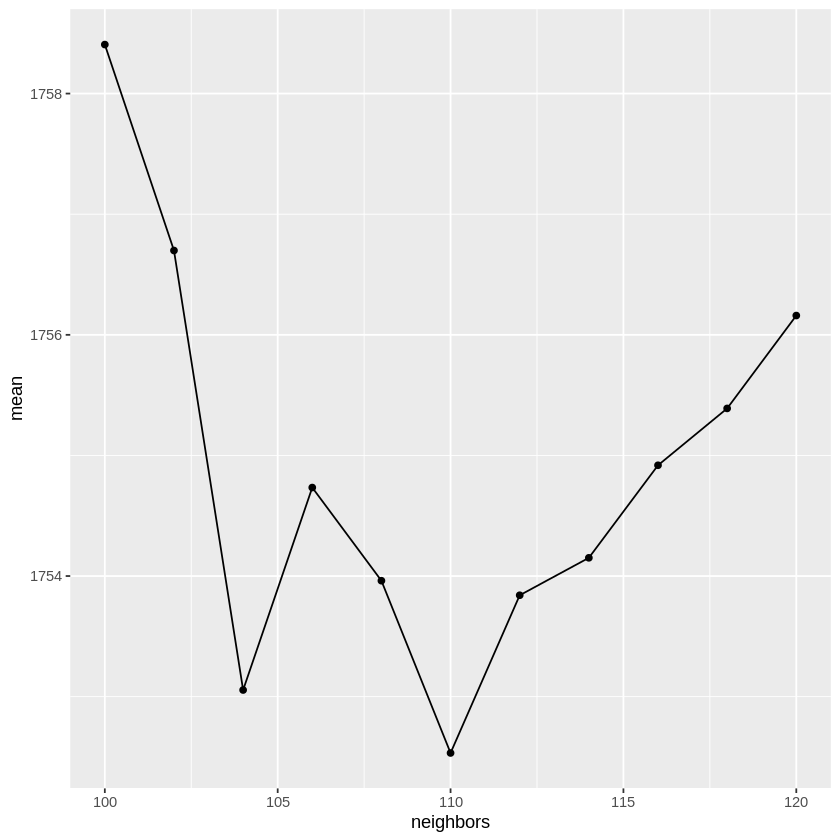

In [15]:
set.seed(5342)
# data analysis (knn regression) - tuning

# testing which predictors to include and running cross-validation

# df: best k = 968 - rmse = 1877.093
# bp: best k: 588 - rmse = 1864.006
# height: best k = 717 -  rmse = 1772.999
# df and bp: best k = 454 - rmse = 1863.363
# height and bp: best k = 110 - rmse = 1752.533 <- best fit
# height and df: best k = 162 - rmse = 1767.332
# height, df, bp: best k = 28 - rmse = 1781.096

knn_recipe <- recipe(rank_points ~ height + bp_percent, data = player_train) |> # adjusted which predictors were included and ran cross-validation for each combination
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_train_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_train_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_train_spec)

vfold <- vfold_cv(player_train, v = 5, strata = rank_points)
gridvals <- tibble(neighbors = seq(from = 100, to = 120, by = 2)) # prior testing allowed the range to be narrowed, to find the absolute best k

knn_train_results <- knn_train_workflow |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min <- knn_train_results |> filter(mean == min(mean)) # finding the lowest rmse k-value
min

k_win_selec <- ggplot(knn_train_results, aes(x = neighbors, y = mean)) + geom_point() + geom_line() # plot of cross-validation
k_win_selec

*KNN Regression Model & Testing*

In [16]:
# data analysis (knn regression) - model & testing

# model
knn_recipe <- recipe(rank_points ~ bp_percent + height, data = player_train) |> # optimal predictor selection from tuning
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_model_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 110) |> # optimal k-value from tuning
    set_engine("kknn") |>
    set_mode("regression")

knn_model_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_model_spec) |>
    fit(player_train)
knn_model_workflow

# testing
knn_test_results <- knn_model_workflow |>
    predict(player_test) |>
    bind_cols(player_test) |>
    metrics(truth = rank_points, estimate = .pred) |>
    filter(.metric == "rmse")
knn_test_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(110,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 1037.636
Minimal mean squared error: 3069871
Best kernel: rectangular
Best k: 110

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1659.649


*Linear Regression Tuning*

In [38]:
set.seed(7893)
# data analysis (linear regression) - tuning predictors

# testing which predictors to include

# df: rmse = 1872.564
# bp: rmse = 1871.75
# height: rmse = 1862.672
# df and bp: rmse = 1869.826
# height and bp: rmse = 1860.603
# height and df: rmse = 1859.49
# height, df, and bp: rmse = 1857.377 <- best fit

linear_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

linear_recipe <- recipe(rank_points ~ height + double_faults + bp_percent, data = player_train) # adjusted which predictors were included and checked rmse for each combination

linear_workflow <- workflow() |>
    add_recipe(linear_recipe) |>
    add_model(linear_spec) |>
    fit(player_train)

linear_train_results <- linear_workflow |>
    predict(player_train) |>
    bind_cols(player_train) |>
    metrics(truth = rank_points, estimate = .pred) |>
    filter(.metric == "rmse")
linear_train_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1857.21


*Linear Regression Model & Testing*

In [42]:
# data analysis (linear regression) - model & testing

# model 
linear_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

linear_recipe <- recipe(rank_points ~ height + double_faults + bp_percent, data = player_train) # optimal predictor selection from tuning

linear_workflow <- workflow() |>
    add_recipe(linear_recipe) |>
    add_model(linear_spec) |>
    fit(player_train)
linear_workflow

# testing
linear_test_results <- linear_workflow |>
    predict(player_test) |>
    bind_cols(player_test) |>
    metrics(truth = rank_points, estimate = .pred) |>
    filter(.metric == "rmse")
linear_test_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
  (Intercept)         height  double_faults     bp_percent  
    -3471.622         27.673        -45.158          3.465  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1761.593


***Analysis Visualizations*** <br>
Since the KNN model and linear models have too many dimensions (3 and 4 respectively) to visualize, the plots shown below will use one predictor each to show the relationships. The plotted models are less accurate than the multivariable ones actually used for the analysis, but allow for vizualization.

In [34]:
# analysis visualization (knn & linear)

# plots of knn regression analysis

# plots of linear regression analysis


**Discussion**<br>
Using our expository analysis of data collected on matches between professional male tennis players, we will create a model that can roughly predict rank points of a player in a match based on their physical and skill indicating attributes such as height, the number of double faults they commit, and their break point save percentage. These variables were selected as they had the most significant relationship when plotted against rank points, and this can be seen in the plots above. For the height vs. rank points graph it is observed that average heights (from 180-195 cm) are preferred, while shorter players do much worse. In opposition, the lower range of double faults tends to be associated with more rank points, which makes logical sense as losing more serves would lose a player points. Finally, the graph on break point save percentage provides a connection between the player’s ability to come back from almost losing on the opponents serve; to do this they must gain a point. In Jeff Sackmann's dataset explored above, the average break point percentage was 59.17%, which agrees with Reid et al.'s statistics of the top 100 male tennis players in which the average break point per player is 60.5%. Additionally, as seen in Jeff Sackmann's dataset there is an average of 3.203 double faults per math per player which is slightly greater than the 2.55 average of double faults among the top 100 male tennis players (Reid et al., 2010). Like our data analysis on double faults, the response we achieved is logical, where winning points and having a higher percentage of come-backs would be correlated with having higher rank points per match. Our linear and k-nearest-neighbor regression model will use these three predictors to determine player rank points per match with a RMSE of 1752.556 (knn) and 1828.507 (linear), which is a comfortable level of accuracy.
Using our aforementioned model, one could achieve a heightened knowledge set which aids in predicting the outcome of new players and thus maybe how a tournament may turn out based on physical and skill attributes such as height, number of double faults, and ratio of break point saves. These kind of abilities could be useful in new casting, career projecting and planning, training simulations, and betting. In the true format of exceptional models, this one can be further expanded on when the situation or technology calls for it. Possible improvements could include: adding more variables and using a more complex quantifier for playing capability than rank points. The data also hints at a future question that we will not pursue here, but could be interesting; how well can we predict the winner or loser of a tennis match based on their rank points or other relevant data? What factors are applicable to female athletes? How does the male data compare to female? 

**References**<br>
Reid, M., McMurtrie, D., & Crespo, M. (2010). The relationship between match statistics and top 100 ranking in professional men’s tennis. International Journal of Performance Analysis in Sport, 10(2), 131–138. https://doi.org/10.1080/24748668.2010.11868509